In [1]:
# Cell 1: Installations
!pip install spacy beautifulsoup4 lxml requests nltk plotly -q
!python -m spacy download en_core_web_sm -q

print("✓ Packages installed")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 90.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
✓ Packages installed


In [2]:
# Cell 2: Imports
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import requests
from bs4 import BeautifulSoup
import time
import spacy
import nltk
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

# Load spaCy
nlp = spacy.load('en_core_web_sm')

print("✓ All imports loaded")

✓ All imports loaded


In [3]:
# Cell 3: Load and inspect dataset
df = pd.read_csv('master_dataset_final.csv')

print(f"Shape: {df.shape}")
print(f"\nColumns:\n{df.columns.tolist()}")
print(f"\n{'='*60}")
print("First few rows:")
df.head()

Shape: (1466, 19)

Columns:
['Index', 'volume', 'Name', 'Category', 'Type', 'Date', 'Place', 'Source', 'Audience', 'Language', 'section', 'genre', 'href', 'full_url', 'filename', 'has_html', 'has_date', 'has_place', 'has_audience']

First few rows:


,Index,volume,Name,Category,Type,Date,Place,Source,Audience,Language,section,genre,href,full_url,filename,has_html,has_date,has_place,has_audience
0,1,1.0,Introduction,Editorial Foreword,NaN,1907/07/04,NaN,NaN,NaN,English,raja-yoga,Treatises,volume_1/raja-yoga/introduction.htm,https://www.ramakrishnavivekananda.info/viveka...,introduction.htm,True,True,False,False
1,2,1.0,Response to Welcome,Addresses at the Parliament of Religions,Lecture,1893/09/11,"USA, IL, Chicago, World Fair",Newspaper Reports,Lecture Attendees,English,addresses_at_the_parliament,Lectures,volume_1/addresses_at_the_parliament/v1_c1_res...,https://www.ramakrishnavivekananda.info/viveka...,v1_c1_response_to_welcome.htm,True,True,True,True
2,3,1.0,Why We Disagree,Addresses at the Parliament of Religions,Lecture,1893/09/15,"USA, IL, Chicago, World Fair",NaN,Lecture Attendees,English,addresses_at_the_parliament,Lectures,volume_1/addresses_at_the_parliament/v1_c1_why...,https://www.ramakrishnavivekananda.info/viveka...,v1_c1_why_we_disagreee.htm,True,True,True,True
3,4,1.0,Paper on Hinduism,Addresses at the Parliament of Religions,Lecture,1893/09/19,"USA, IL, Chicago, World Fair",NaN,Lecture Attendees,English,addresses_at_the_parliament,Lectures,volume_1/addresses_at_the_parliament/v1_c1_pap...,https://www.ramakrishnavivekananda.info/viveka...,v1_c1_paper_on_hinduism.htm,True,True,True,True
4,5,1.0,Religion not the Crying Need of India,Addresses at the Parliament of Religions,Lecture,1893/09/20,"USA, IL, Chicago, World Fair",NaN,Lecture Attendees,English,addresses_at_the_parliament,Lectures,volume_1/addresses_at_the_parliament/v1_c1_cry...,https://www.ramakrishnavivekananda.info/viveka...,v1_c1_crying_need.htm,True,True,True,True


In [4]:
# Cell 4: Corpus overview
df_corpus = df[df['has_html'] == True].copy()

print(f"Total rows: {len(df)}")
print(f"Scrapable documents: {len(df_corpus)} ({len(df_corpus)/len(df)*100:.1f}%)")
print(f"\n{'='*60}")
print("GENRE DISTRIBUTION:")
print(df_corpus['genre'].value_counts())
print(f"\n{'='*60}")
print("METADATA COVERAGE:")
print(f"  Date: {df_corpus['has_date'].sum()} ({df_corpus['has_date'].mean()*100:.1f}%)")
print(f"  Place: {df_corpus['has_place'].sum()} ({df_corpus['has_place'].mean()*100:.1f}%)")
print(f"  Audience: {df_corpus['has_audience'].sum()} ({df_corpus['has_audience'].mean()*100:.1f}%)")
print(f"\n{'='*60}")
print("LANGUAGE DISTRIBUTION:")
print(df_corpus['Language'].value_counts())

Total rows: 1466
Scrapable documents: 1418 (96.7%)

GENRE DISTRIBUTION:
genre
Letters          774
Lectures         266
Reports          140
Writings          96
Other             53
Treatises         50
Conversations     39
Name: count, dtype: int64

METADATA COVERAGE:
  Date: 1174 (82.8%)
  Place: 1177 (83.0%)
  Audience: 973 (68.6%)

LANGUAGE DISTRIBUTION:
Language
English     1139
Bengali      213
Sanskrit      11
Hindi          3
French         3
 English       1
Name: count, dtype: int64


In [5]:
# Cell 5: Build stratified sample strategy
# Remove Reports (newspaper articles ABOUT him, not BY him)
df_clean = df_corpus[df_corpus['genre'] != 'Reports'].copy()

print(f"Documents after removing Reports: {len(df_clean)}")
print(f"\nGenre distribution:")
print(df_clean['genre'].value_counts())
print(f"\n{'='*60}")

# Check volume distribution
print("Volume distribution:")
print(df_clean['volume'].value_counts().sort_index())

Documents after removing Reports: 1278

Genre distribution:
genre
Letters          774
Lectures         266
Writings          96
Other             53
Treatises         50
Conversations     39
Name: count, dtype: int64

Volume distribution:
volume
1.0     51
2.0     34
3.0     56
4.0     65
5.0    179
6.0    216
7.0    155
8.0    246
9.0    276
Name: count, dtype: int64


In [6]:
# Cell 6: Create stratified sample (10 per genre per volume)
from collections import defaultdict

sample_docs = []
sample_strategy = defaultdict(lambda: defaultdict(int))

# Group by volume and genre
for volume in sorted(df_clean['volume'].unique()):
    for genre in df_clean['genre'].unique():
        subset = df_clean[(df_clean['volume'] == volume) & (df_clean['genre'] == genre)]

        if len(subset) > 0:
            # Sample up to 10 docs (or all if fewer than 10)
            n_sample = min(10, len(subset))
            sampled = subset.sample(n=n_sample, random_state=42)
            sample_docs.append(sampled)
            sample_strategy[volume][genre] = n_sample

# Combine all samples
df_sample = pd.concat(sample_docs, ignore_index=True)

print(f"Total sample size: {len(df_sample)} documents")
print(f"\n{'='*60}")
print("Sample breakdown by genre:")
print(df_sample['genre'].value_counts())
print(f"\n{'='*60}")
print("Sample breakdown by volume:")
print(df_sample['volume'].value_counts().sort_index())

Total sample size: 273 documents

Sample breakdown by genre:
genre
Lectures         90
Writings         54
Letters          50
Other            35
Treatises        30
Conversations    14
Name: count, dtype: int64

Sample breakdown by volume:
volume
1.0    20
2.0    24
3.0    30
4.0    20
5.0    43
6.0    30
7.0    35
8.0    31
9.0    40
Name: count, dtype: int64


In [7]:
# Cell 7: Show sampling strategy matrix
import pandas as pd

# Create matrix showing docs sampled per volume/genre combo
strategy_matrix = pd.DataFrame(sample_strategy).T.fillna(0).astype(int)
strategy_matrix = strategy_matrix.reindex(sorted(strategy_matrix.index))

print("SAMPLING STRATEGY (docs per volume/genre):")
print(strategy_matrix)
print(f"\n{'='*60}")
print(f"Total documents in sample: {len(df_sample)}")
print(f"Genres covered: {df_sample['genre'].nunique()}")
print(f"Volumes covered: {df_sample['volume'].nunique()}")

SAMPLING STRATEGY (docs per volume/genre):
     Treatises  Lectures  Other  Writings  Letters  Conversations
1.0         10        10      0         0        0              0
2.0         10        10      4         0        0              0
3.0         10        10     10         0        0              0
4.0          0        10      0        10        0              0
5.0          0        10     10         9       10              4
6.0          0        10      0        10       10              0
7.0          0        10      0         5       10             10
8.0          0        10      1        10       10              0
9.0          0        10     10        10       10              0

Total documents in sample: 273
Genres covered: 6
Volumes covered: 9


In [8]:
# Cell 8: Sample one URL from each genre to inspect HTML structure
sample_urls = {}
for genre in df_sample['genre'].unique():
    sample_doc = df_sample[df_sample['genre'] == genre].iloc[0]
    sample_urls[genre] = {
        'url': sample_doc['full_url'],
        'name': sample_doc['Name'],
        'volume': sample_doc['volume']
    }

print("Sample URLs by genre:")
for genre, info in sample_urls.items():
    print(f"\n{genre}:")
    print(f"  {info['name']} (Vol {info['volume']})")
    print(f"  {info['url']}")

Sample URLs by genre:

Treatises:
  The Ideal of Karma-Yoga (Vol 1.0)
  https://www.ramakrishnavivekananda.info/vivekananda/volume_1/karma-yoga/the_ideal.htm

Lectures:
  What is Religion? (Vol 1.0)
  https://www.ramakrishnavivekananda.info/vivekananda/volume_1/lectures_and_discourses/what_is_religion.htm

Other:
  The Powers of the Mind (Vol 2.0)
  https://www.ramakrishnavivekananda.info/vivekananda/volume_2/the_powers_of_the_mind.htm

Writings:
  The Song of The Sannyasin (Vol 4.0)
  https://www.ramakrishnavivekananda.info/vivekananda/volume_4/writings_poems/the_song_of_the_sannyasin.htm

Letters:
  XVIII Alasinga (Vol 5.0)
  https://www.ramakrishnavivekananda.info/vivekananda/volume_5/epistles_first_series/018_alasinga.htm

Conversations:
  Shri Surendra Nath Sen (Vol 5.0)
  https://www.ramakrishnavivekananda.info/vivekananda/volume_5/conversations_and_dialogues/ii_v_shri_surendra_nath_sen.htm


In [9]:
# Cell 9: Fetch and inspect HTML structure for each genre
import requests
from bs4 import BeautifulSoup

html_structures = {}

for genre, info in sample_urls.items():
    print(f"\n{'='*60}")
    print(f"GENRE: {genre}")
    print(f"Document: {info['name']}")
    print(f"{'='*60}")

    try:
        response = requests.get(info['url'], timeout=10)
        soup = BeautifulSoup(response.content, 'html.parser')

        # Show main structure
        print(f"\nMain tags found:")
        for tag in ['article', 'main', 'div', 'section']:
            elements = soup.find_all(tag, limit=5)
            if elements:
                print(f"  <{tag}>: {len(soup.find_all(tag))} total")
                # Show classes/ids of first few
                for i, elem in enumerate(elements[:3]):
                    if elem.get('class'):
                        print(f"    [{i}] class='{' '.join(elem.get('class'))}'")
                    if elem.get('id'):
                        print(f"    [{i}] id='{elem.get('id')}'")

        # Store soup for later inspection
        html_structures[genre] = soup

        time.sleep(1)  # Be polite

    except Exception as e:
        print(f"ERROR: {e}")


GENRE: Treatises
Document: The Ideal of Karma-Yoga

Main tags found:
  <div>: 1 total

GENRE: Lectures
Document: What is Religion?

Main tags found:
  <div>: 1 total

GENRE: Other
Document: The Powers of the Mind

Main tags found:
  <div>: 1 total

GENRE: Writings
Document: The Song of The Sannyasin

Main tags found:
  <div>: 1 total

GENRE: Letters
Document: XVIII Alasinga

Main tags found:
  <div>: 1 total

GENRE: Conversations
Document: Shri Surendra Nath Sen

Main tags found:
  <div>: 1 total


In [10]:
# Cell 10: Show actual text content preview for each genre
for genre, soup in html_structures.items():
    print(f"\n{'='*60}")
    print(f"GENRE: {genre}")
    print(f"{'='*60}")

    # Get all text
    text = soup.get_text(separator=' ', strip=True)

    # Show first 500 characters
    print(f"\nFirst 500 chars of extracted text:")
    print(text[:500])
    print("\n...")


GENRE: Treatises

First 500 chars of extracted text:
The ideal ← Home / Complete-Works / Volume 1 / Karma-Yoga / → CHAPTER VIII THE IDEAL OF KARMA-YOGA The grandest idea in the religion of the Vedanta is that we
may reach the same goal by different paths; and these paths I have
generalised into four, viz those of work, love, psychology, and
knowledge. But you must, at the same time, remember that these
divisions are not very marked and quite exclusive of each other. Each
blends into the other. But according to the type which prevails, we
name the 

...

GENRE: Lectures

First 500 chars of extracted text:
What is religion ← Home / Complete-Works / Volume 1 / Lectures
and Discourses / → WHAT IS RELIGION? A huge locomotive has rushed on over the line and a small worm
that was creeping upon one of the rails saved its life by crawling out
of the path of the locomotive. Yet this little worm, so insignificant
that it can be crushed in a moment, is a living something, while this
locomotive, s

In [13]:
# Remove Conversations from df_sample
print("Before removing Conversations:")
print(f"Total documents: {len(df_sample)}")
print(f"\nGenre distribution:")
print(df_sample['genre'].value_counts())

# Remove Conversations
df_sample_clean = df_sample[df_sample['genre'] != 'Conversations'].copy()

print("\n" + "="*60)
print("\nAfter removing Conversations:")
print(f"Total documents: {len(df_sample_clean)}")
print(f"\nGenre distribution:")
print(df_sample_clean['genre'].value_counts())

# Show volume distribution
print("\n" + "="*60)
print("\nDocuments per volume:")
print(df_sample_clean['volume'].value_counts().sort_index())

Before removing Conversations:
Total documents: 273

Genre distribution:
genre
Lectures         90
Writings         54
Letters          50
Other            35
Treatises        30
Conversations    14
Name: count, dtype: int64


After removing Conversations:
Total documents: 259

Genre distribution:
genre
Lectures     90
Writings     54
Letters      50
Other        35
Treatises    30
Name: count, dtype: int64


Documents per volume:
volume
1.0    20
2.0    24
3.0    30
4.0    20
5.0    39
6.0    30
7.0    25
8.0    31
9.0    40
Name: count, dtype: int64


In [15]:
# Cell 11: Scrape all documents in df_sample_clean
import re

def extract_clean_content_v3(url):
    """Extract clean text - remove nav and first metadata paragraph"""
    try:
        response = requests.get(url, timeout=15)
        soup = BeautifulSoup(response.content, 'html.parser')

        # Remove navigation paragraph (class="nav")
        nav = soup.find('p', class_='nav')
        if nav:
            nav.decompose()

        # Remove h2 title
        title = soup.find('h2')
        if title:
            title.decompose()

        # Remove the FIRST remaining paragraph (metadata: chapter/date/location/translation)
        paragraphs = soup.find_all('p')
        if paragraphs:
            paragraphs[0].decompose()  # This is the metadata paragraph

        # Get remaining text
        text = soup.get_text(separator=' ', strip=True)

        # Final cleanup of any stray artifacts
        text = re.sub(r'\s+', ' ', text)  # Multiple spaces
        text = text.strip()

        # Calculate word count
        word_count = len(text.split())

        return {
            'text_content': text,
            'word_count': word_count,
            'scrape_success': True,
            'scrape_error': None
        }

    except Exception as e:
        return {
            'text_content': None,
            'word_count': 0,
            'scrape_success': False,
            'scrape_error': str(e)
        }

# Scrape all documents
print(f"Starting to scrape {len(df_sample_clean)} documents...")
print(f"Estimated time: ~{len(df_sample_clean) * 1.5 / 60:.1f} minutes\n")

scraped_data = []
failed_scrapes = []
doc_count = 0

for idx, row in df_sample_clean.iterrows():
    doc_count += 1
    url = row['full_url']
    doc_name = row['Name'][:50]  # Truncate long names
    genre = row['genre']

    # Scrape the document
    result = extract_clean_content_v3(url)

    # Show progress for EVERY document
    status = "✓" if result['scrape_success'] else "✗"
    print(f"[{doc_count}/{len(df_sample_clean)}] {status} {genre:12s} | {result['word_count']:5d} words | {doc_name}")

    # Track failures
    if not result['scrape_success']:
        failed_scrapes.append({
            'Index': row['Index'],
            'Name': row['Name'],
            'url': url,
            'error': result['scrape_error']
        })

    # Add to results
    scraped_data.append(result)

    # Polite delay
    time.sleep(1)

# Add scraped columns to dataframe
df_sample_clean['text_content'] = [d['text_content'] for d in scraped_data]
df_sample_clean['word_count'] = [d['word_count'] for d in scraped_data]
df_sample_clean['scrape_success'] = [d['scrape_success'] for d in scraped_data]
df_sample_clean['scrape_error'] = [d['scrape_error'] for d in scraped_data]

print(f"\n{'='*60}")
print("SCRAPING COMPLETE")
print(f"{'='*60}")
print(f"Total documents: {len(df_sample_clean)}")
print(f"Successful scrapes: {df_sample_clean['scrape_success'].sum()}")
print(f"Failed scrapes: {len(failed_scrapes)}")

if failed_scrapes:
    print(f"\nFailed documents:")
    for fail in failed_scrapes:
        print(f"  - {fail['Name']} (Index {fail['Index']}): {fail['error']}")

Starting to scrape 259 documents...
Estimated time: ~6.5 minutes

[1/259] ✓ Treatises    |  3651 words | The Ideal of Karma-Yoga
[2/259] ✓ Treatises    |  3381 words | Dhyana and Samadhi
[3/259] ✓ Treatises    |  1801 words | Introduction
[4/259] ✓ Treatises    |  1801 words | Introduction
[5/259] ✓ Treatises    |  3411 words | The First Steps
[6/259] ✓ Treatises    |   826 words | Preface
[7/259] ✓ Treatises    |  1972 words | The Psychic Prana
[8/259] ✓ Treatises    |  2970 words | Karma in its Effect on Character
[9/259] ✓ Treatises    |  4567 words | Powers
[10/259] ✓ Treatises    |  3183 words | We help ourselves, not the world
[11/259] ✓ Lectures     |  3731 words | What is Religion?
[12/259] ✓ Lectures     |  1752 words | The Spirit and Influence of Vedanta
[13/259] ✓ Lectures     |  4022 words | Vedic Religious Ideals
[14/259] ✓ Lectures     |  4402 words | Gita III
[15/259] ✓ Lectures     |   481 words | Response to Welcome
[16/259] ✓ Lectures     |  6096 words | Reason and Re

In [18]:
# Cell 14: Let's understand the HTML structure better
print("ANALYZING HTML STRUCTURE")
print("="*60)

# Test one URL in detail
url = "https://www.ramakrishnavivekananda.info/vivekananda/volume_7/notes_of_class_talks_and_lectures/notes_of_class_talks/on_music.htm"
response = requests.get(url, timeout=15)
soup = BeautifulSoup(response.content, 'html.parser')

print("\nORIGINAL HTML:")
paragraphs = soup.find_all('p')
for i, p in enumerate(paragraphs):
    print(f"\nP[{i}] (class={p.get('class')}): {p.get_text(strip=True)[:150]}")

print("\n" + "="*60)
print("\nAFTER REMOVING NAV:")
nav = soup.find('p', class_='nav')
if nav:
    nav.decompose()
paragraphs = soup.find_all('p')
for i, p in enumerate(paragraphs):
    print(f"\nP[{i}]: {p.get_text(strip=True)[:150]}")

print("\n" + "="*60)
print("\nAFTER REMOVING H2:")
title = soup.find('h2')
if title:
    title.decompose()
    print(f"Removed H2: {title.get_text(strip=True)}")

print("\n" + "="*60)
print("\nREMAINING PARAGRAPHS:")
paragraphs = soup.find_all('p')
for i, p in enumerate(paragraphs):
    print(f"\nP[{i}]: {p.get_text(strip=True)}")

print("\n" + "="*60)
print("\nIF WE REMOVE P[0], WE GET:")
if paragraphs:
    print(f"P[0] would be removed: {paragraphs[0].get_text(strip=True)[:150]}")
    remaining_text = ' '.join([p.get_text(strip=True) for p in paragraphs[1:]])
    print(f"\nRemaining text: {remaining_text}")
    print(f"Word count: {len(remaining_text.split())}")

ANALYZING HTML STRUCTURE

ORIGINAL HTML:

P[0] (class=['nav']): ←Home/Complete-Works/Volume 7/Notes
of Class Talks and Lectures/Notes of Class Talks/→

P[1] (class=None): There is science in Dhrupad, Kheyal, etc., but it is in
Kirtana, i.e. in Mâthura and Viraha and other like compositions that
there is real music — for


AFTER REMOVING NAV:

P[0]: There is science in Dhrupad, Kheyal, etc., but it is in
Kirtana, i.e. in Mâthura and Viraha and other like compositions that
there is real music — for


AFTER REMOVING H2:
Removed H2: 


REMAINING PARAGRAPHS:

P[0]: There is science in Dhrupad, Kheyal, etc., but it is in
Kirtana, i.e. in Mâthura and Viraha and other like compositions that
there is real music — for there is feeling. Feeling is the soul, the
secret of everything. There is more music in common people's songs, and
they should be collected together. The science of Dhrupad etc., applied
to the music of Kirtana will produce the perfect music.


IF WE REMOVE P[0], WE GET:
P[0] would

In [26]:
# Cell 20: Create PROPER functional dataset with ALL filters
print("CREATING PROPER FUNCTIONAL DATASET")
print("="*60)

print(f"\nStarting with original df: {len(df)} documents")

# Apply ALL filters
print("\nApplying filters:")

# 1. Remove Reports
df_filtered = df[df['genre'] != 'Reports'].copy()
print(f"1. After removing Reports: {len(df_filtered)}")

# 2. Remove Conversations
df_filtered = df_filtered[df_filtered['genre'] != 'Conversations'].copy()
print(f"2. After removing Conversations: {len(df_filtered)}")

# 3. Keep only English
df_filtered = df_filtered[df_filtered['Language'] == 'English'].copy()
print(f"3. After keeping only English: {len(df_filtered)}")

# 4. Remove entries without HTML links
df_filtered = df_filtered[df_filtered['has_html'] == True].copy()
print(f"4. After removing entries without HTML: {len(df_filtered)}")

# 5. Remove entries where full_url is NaN
df_filtered = df_filtered[df_filtered['full_url'].notna()].copy()
print(f"5. After removing NaN URLs: {len(df_filtered)}")

print("\n" + "="*60)
print("FINAL FUNCTIONAL DATASET")
print("="*60)
print(f"Total documents: {len(df_filtered)}")
print("\nBy genre:")
print(df_filtered['genre'].value_counts())
print("\nBy volume:")
print(df_filtered['volume'].value_counts().sort_index())

# Save it
output_filename = 'swamiji_functional_dataset.csv'
df_filtered.to_csv(output_filename, index=False)
print(f"\n✓ Saved functional dataset to: {output_filename}")

# Update our working variable
df_functional = df_filtered.copy()
print(f"\n✓ Created df_functional with {len(df_functional)} documents")

CREATING PROPER FUNCTIONAL DATASET

Starting with original df: 1466 documents

Applying filters:
1. After removing Reports: 1326
2. After removing Conversations: 1287
3. After keeping only English: 1034
4. After removing entries without HTML: 998
5. After removing NaN URLs: 998

FINAL FUNCTIONAL DATASET
Total documents: 998

By genre:
genre
Letters      614
Lectures     236
Writings      59
Treatises     50
Other         39
Name: count, dtype: int64

By volume:
volume
1.0     51
2.0     34
3.0     53
4.0     49
5.0    131
6.0    135
7.0     98
8.0    194
9.0    253
Name: count, dtype: int64

✓ Saved functional dataset to: swamiji_functional_dataset.csv

✓ Created df_functional with 998 documents


In [27]:
# Cell 21: Scrape with checkpoints and progress tracking
import time

print(f"SCRAPING HTML FOR ALL {len(df_functional)} DOCUMENTS")
print("="*60)

# Create df_functional_populated (copy if starting fresh, or continue existing)
if 'df_functional_populated' not in dir():
    df_functional_populated = df_functional.copy()
    print("✓ Created new df_functional_populated")
else:
    print("✓ Continuing with existing df_functional_populated")

# Initialize html_content column if it doesn't exist
if 'html_content' not in df_functional_populated.columns:
    df_functional_populated['html_content'] = None

# Check progress
already_scraped = df_functional_populated['html_content'].notna().sum()
total_docs = len(df_functional_populated)
remaining = total_docs - already_scraped

print(f"\nProgress status:")
print(f"  Already scraped: {already_scraped} ({already_scraped/total_docs*100:.1f}%)")
print(f"  Remaining: {remaining}")
print(f"  Estimated time: ~{remaining * 1.5 / 60:.1f} minutes\n")

failed_scrapes = []
doc_count = 0
scraped_this_session = 0

for idx, row in df_functional_populated.iterrows():
    doc_count += 1

    # Skip if already scraped
    if pd.notna(df_functional_populated.at[idx, 'html_content']):
        continue

    url = row['full_url']
    doc_name = str(row['Name'])[:40]
    genre = str(row['genre'])

    try:
        response = requests.get(url, timeout=15)
        html_content = response.text

        # SAVE IMMEDIATELY to dataframe
        df_functional_populated.at[idx, 'html_content'] = html_content
        scraped_this_session += 1

        # Calculate progress
        total_scraped = already_scraped + scraped_this_session
        progress_pct = (total_scraped / total_docs) * 100

        html_size = len(html_content)
        print(f"[{progress_pct:.1f}%] ✓ {genre:12s} | {html_size:6d} bytes | {doc_name}")

    except Exception as e:
        total_scraped = already_scraped + scraped_this_session
        progress_pct = (total_scraped / total_docs) * 100
        print(f"[{progress_pct:.1f}%] ✗ {genre:12s} | ERROR: {str(e)[:30]} | {doc_name}")
        failed_scrapes.append({
            'Index': row['Index'],
            'Name': row['Name'],
            'url': url,
            'error': str(e)
        })
        df_functional_populated.at[idx, 'html_content'] = None

    # CHECKPOINT every 100 documents
    if scraped_this_session > 0 and scraped_this_session % 100 == 0:
        checkpoint_file = f'df_functional_checkpoint_{scraped_this_session}.csv'
        df_functional_populated.to_csv(checkpoint_file, index=False)
        print(f"\n  *** CHECKPOINT SAVED: {checkpoint_file} ({progress_pct:.1f}% complete) ***\n")

    time.sleep(1)

# FINAL SAVE
print(f"\n{'='*60}")
print("SCRAPING COMPLETE")
print(f"{'='*60}")
final_scraped = df_functional_populated['html_content'].notna().sum()
print(f"Total successful: {final_scraped}/{total_docs} ({final_scraped/total_docs*100:.1f}%)")
print(f"Failed: {len(failed_scrapes)}")

if failed_scrapes:
    print(f"\nFailed documents:")
    for fail in failed_scrapes[:10]:  # Show first 10
        print(f"  - {fail['Name']}: {fail['error'][:50]}")
    if len(failed_scrapes) > 10:
        print(f"  ... and {len(failed_scrapes)-10} more")

# Final save
df_functional_populated.to_csv('df_functional_populated.csv', index=False)
print(f"\n✓ FINAL DATASET SAVED: df_functional_populated.csv")

SCRAPING HTML FOR ALL 998 DOCUMENTS
✓ Created new df_functional_populated

Progress status:
  Already scraped: 0 (0.0%)
  Remaining: 998
  Estimated time: ~24.9 minutes

[0.1%] ✓ Treatises    |  10677 bytes | Introduction
[0.2%] ✓ Lectures     |   3689 bytes | Response to Welcome
[0.3%] ✓ Lectures     |   2913 bytes | Why We Disagree
[0.4%] ✓ Lectures     |  29928 bytes | Paper on Hinduism
[0.5%] ✓ Lectures     |   1903 bytes | Religion not the Crying Need of India
[0.6%] ✓ Lectures     |   5580 bytes | Buddhism, the Fulfilment of Hinduism
[0.7%] ✓ Lectures     |   3370 bytes | Address at the Final Session
[0.8%] ✓ Treatises    |  16969 bytes | Karma in its Effect on Character
[0.9%] ✓ Treatises    |  30988 bytes | Each is great in his own place
[1.0%] ✓ Treatises    |  21417 bytes | The Secret of Work
[1.1%] ✓ Treatises    |  17845 bytes | What is Duty?
[1.2%] ✓ Treatises    |  17859 bytes | We help ourselves, not the world
[1.3%] ✓ Treatises    |  26737 bytes | Non-attachment is comp

In [46]:
# Cell 36: Fix the cleaning logic and manually add Kali poem
from bs4 import BeautifulSoup
import re

# First, manually extract and add the Kali poem
kali_idx = df_final[df_final['Name'] == 'Kali the Mother'].index[0]

kali_text = """The stars are blotted out,
The clouds are covering clouds,
It is darkness vibrant, sonant.
In the roaring, whirling wind
Are the souls of a million lunatics
Just loose from the prison-house,
Wrenching trees by the roots,
Sweeping all from the path.

The sea has joined the fray,
And swirls up mountain-waves,
To reach the pitchy sky.
The flash of lurid light
Reveals on every side
A thousand, thousand shades
Of Death begrimed and black —
Scattering plagues and sorrows,
Dancing mad with joy,
Come, Mother, come!

For Terror is Thy name,
Death is in Thy breath,
And every shaking step
Destroys a world for e'er.
Thou "Time", the All-Destroyer!
Come, O Mother, come!
Who dares misery love,
And hug the form of Death,
Dance in Destruction's dance,
To him the Mother comes."""

df_final.at[kali_idx, 'plaintext_clean'] = kali_text
df_final.at[kali_idx, 'word_count_clean'] = len(kali_text.split())

print("FIXED 'Kali the Mother' POEM")
print("="*60)
print(f"Word count: {df_final.at[kali_idx, 'word_count_clean']}")
print(f"\nContent preview:")
print(kali_text[:200])

# Now check for any other problematic poems
print("\n" + "="*60)
print("CHECKING FOR OTHER POEMS WITH class='center'")
print("-"*60)

writings_docs = df_final[df_final['genre'] == 'Writings']
print(f"Total Writings: {len(writings_docs)}")

# Check for very short writings (might be poems)
short_writings = writings_docs[writings_docs['word_count_clean'] < 100]
print(f"\nVery short Writings (< 100 words): {len(short_writings)}")

for idx, row in short_writings.head(10).iterrows():
    print(f"\n  - {row['Name']} ({row['word_count_clean']} words)")
    print(f"    URL: {row['full_url']}")

    # Check if it has center-class paragraphs
    soup = BeautifulSoup(row['html_content'], 'html.parser')
    center_p = soup.find_all('p', class_='center')
    if len(center_p) > 2:  # More than 2 suggests content, not just metadata
        print(f"    ⚠ Has {len(center_p)} center-class paragraphs - might be a poem!")

# Final statistics
print("\n" + "="*60)
print("FINAL STATISTICS")
print("-"*60)
print(f"Documents with 0 words: {(df_final['word_count_clean'] == 0).sum()}")
print(f"Total documents: {len(df_final)}")
print(f"Total words: {df_final['word_count_clean'].sum():,}")

# Save
output_file = 'swamiji_plaintext.csv'
df_final.to_csv(output_file, index=False)
print(f"\n✓ Saved to: {output_file}")

FIXED 'Kali the Mother' POEM
Word count: 133

Content preview:
The stars are blotted out,
The clouds are covering clouds,
It is darkness vibrant, sonant.
In the roaring, whirling wind
Are the souls of a million lunatics
Just loose from the prison-house,
Wrenching

CHECKING FOR OTHER POEMS WITH class='center'
------------------------------------------------------------
Total Writings: 59

Very short Writings (< 100 words): 6

  - A Benediction (54 words)
    URL: https://www.ramakrishnavivekananda.info/vivekananda/volume_6/writings_prose_and_poems/a_benediction.htm

  - Light (34 words)
    URL: https://www.ramakrishnavivekananda.info/vivekananda/volume_8/writings_poems/light.htm

  - To an Early Violet (80 words)
    URL: https://www.ramakrishnavivekananda.info/vivekananda/volume_8/writings_poems/to_an_early_violet.htm

  - The Dance of Shiva (57 words)
    URL: https://www.ramakrishnavivekananda.info/vivekananda/volume_8/writings_poems/the_dance_of_shiva.htm

  - Shiva in Ecstasy (57 

DEEP DIVE: 10 RESEARCH QUESTIONS

Q1: THE 1898-1899 COLLAPSE

Genre distribution by year (document counts):

1889:
  Letters     :   1 docs,     39 words

1890:
  Letters     :   1 docs,    263 words

1891:
  Letters     :   3 docs,    113 words

1892:
  Letters     :   5 docs,    708 words
  Lectures    :   1 docs,  3,078 words

1893:
  Letters     :  16 docs,  5,070 words
  Lectures    :  10 docs,  4,126 words
  Writings    :   1 docs,    239 words

1894:
  Letters     : 108 docs, 19,192 words
  Lectures    :  10 docs,  7,773 words
  Writings    :   5 docs,  2,093 words

1895:
  Letters     : 105 docs, 12,650 words
  Lectures    :  47 docs, 19,029 words
  Writings    :   7 docs,  6,162 words

1896:
  Letters     :  87 docs, 11,673 words
  Lectures    :  13 docs, 33,299 words
  Treatises   :   2 docs,  3,920 words
  Writings    :   2 docs,  1,576 words

1897:
  Letters     :  42 docs,  6,474 words
  Lectures    :  11 docs, 20,750 words
  Writings    :   2 docs,    117 words

1898:
  L

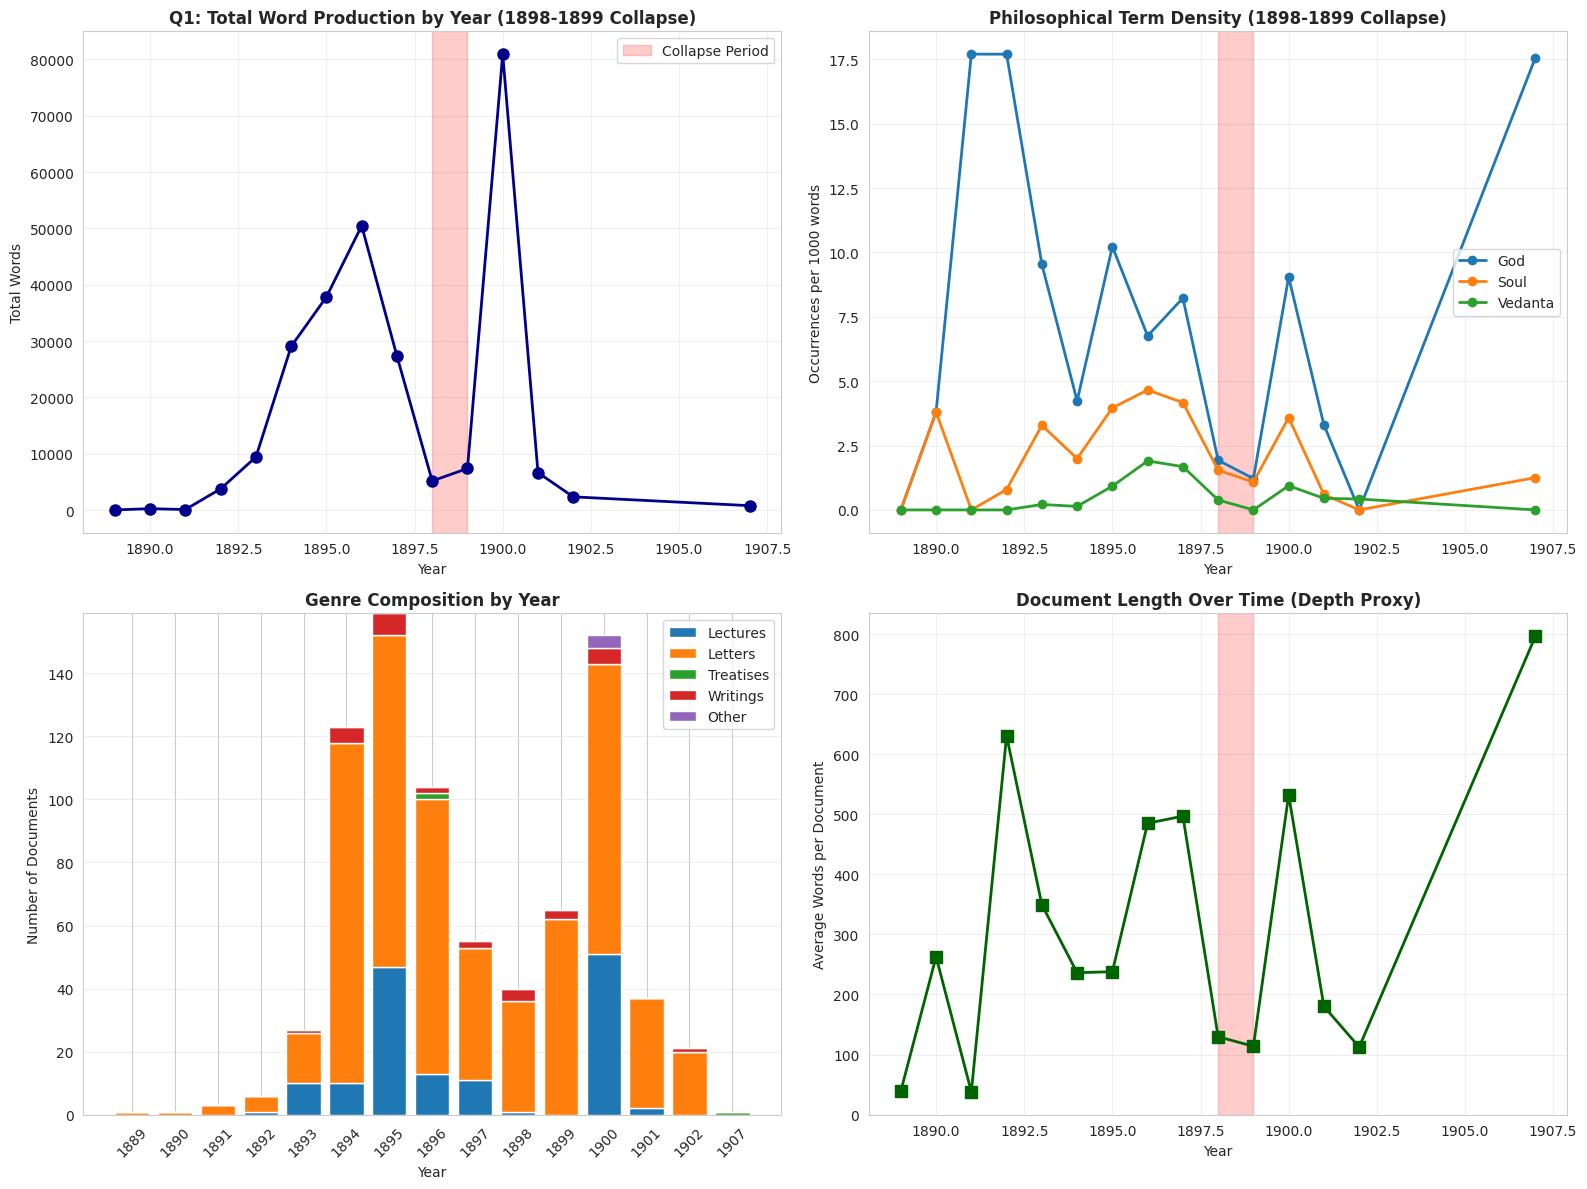


Q2: SANSKRIT TERM EXTINCTION POST-1897

Sanskrit vs English term usage (normalized per 1000 words):

Year   Atman    Brahman  Maya     Karma    | God      Soul     Self    
--------------------------------------------------------------------------------
1893   0.00     0.42     0.00     0.00     | 9.54     3.29     0.32    
1894   0.10     0.03     0.00     0.17     | 4.23     2.00     0.52    
1895   1.93     1.27     1.14     0.48     | 10.23    3.96     2.33    
1896   0.50     0.99     0.59     0.24     | 6.76     4.66     1.27    
1897   1.32     0.73     0.29     1.39     | 8.23     4.17     1.06    
1898   0.00     0.00     0.00     1.16     | 1.93     1.54     0.58    
1899   0.14     0.00     0.00     1.08     | 1.22     1.08     0.14    
1900   0.05     0.07     0.20     0.35     | 9.04     3.58     1.26    
1901   0.60     0.75     0.00     0.75     | 3.30     0.60     0.00    
1902   0.00     0.42     0.42     0.00     | 0.00     0.00     0.00    
1907   0.00     0.00     

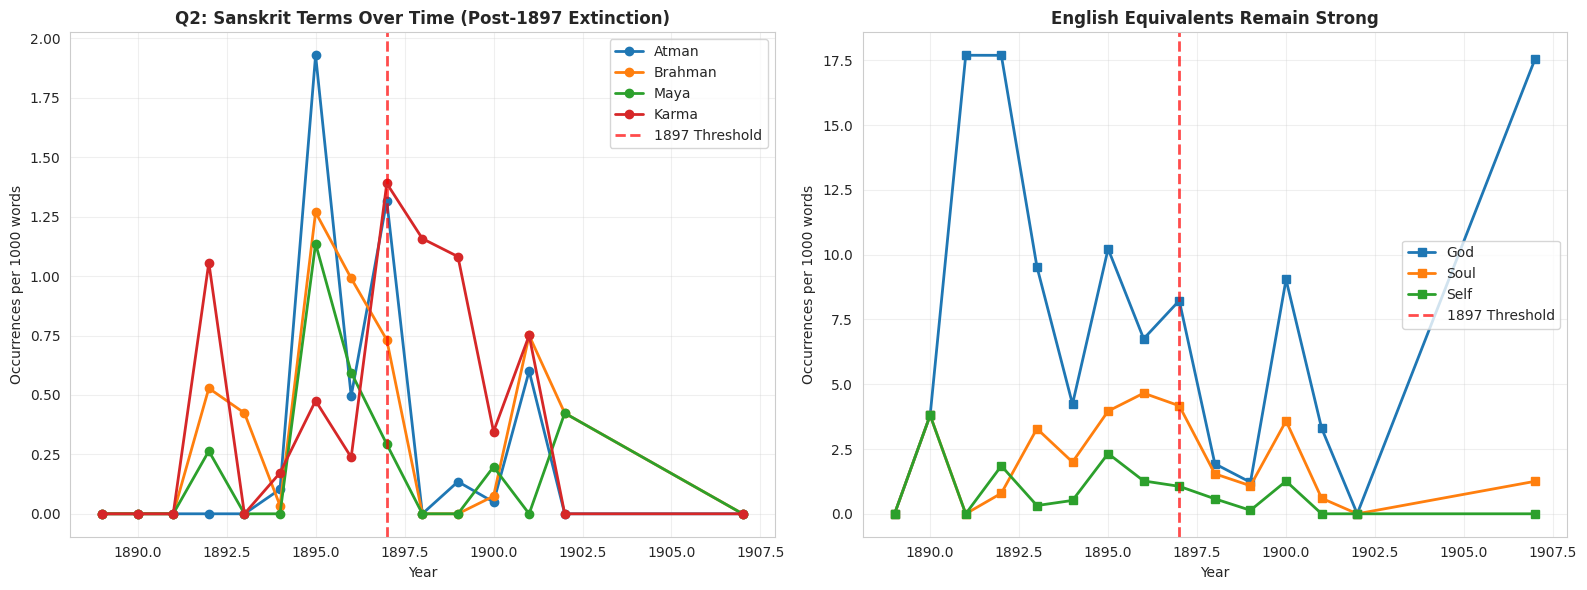


[Continue with Q3-Q10...]
Paste output to continue with remaining questions.


In [50]:
# Cell 39: COMPREHENSIVE DEEP DIVE - All 10 Questions
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
import re

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("="*80)
print("DEEP DIVE: 10 RESEARCH QUESTIONS")
print("="*80)

# ============================================================
# Q1: The 1898-1899 Collapse
# ============================================================
print("\n" + "="*80)
print("Q1: THE 1898-1899 COLLAPSE")
print("="*80)

# Get genre breakdown by year
genre_by_year = defaultdict(lambda: defaultdict(int))
words_by_year_genre = defaultdict(lambda: defaultdict(int))

for doc in doc_tokens:
    matching = corpus_df[corpus_df['Index'] == doc['Index']]
    if len(matching) > 0 and matching.iloc[0]['has_date']:
        year = matching.iloc[0]['year']
        genre = doc['genre']
        genre_by_year[year][genre] += 1
        words_by_year_genre[year][genre] += len([t for t in doc['tokens'] if t not in stop_words])

print("\nGenre distribution by year (document counts):")
for year in sorted(genre_by_year.keys()):
    print(f"\n{int(year)}:")
    for genre, count in sorted(genre_by_year[year].items(), key=lambda x: x[1], reverse=True):
        words = words_by_year_genre[year][genre]
        print(f"  {genre:12s}: {count:3d} docs, {words:6,} words")

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Total words by year
years = sorted(year_tokens.keys())
word_counts = [len(year_tokens[y]) for y in years]
axes[0,0].plot(years, word_counts, marker='o', linewidth=2, markersize=8, color='darkblue')
axes[0,0].axvspan(1898, 1899, alpha=0.2, color='red', label='Collapse Period')
axes[0,0].set_xlabel('Year')
axes[0,0].set_ylabel('Total Words')
axes[0,0].set_title('Q1: Total Word Production by Year (1898-1899 Collapse)', fontsize=12, fontweight='bold')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Philosophical term density
terms_data = []
for year in years:
    god_norm = term_by_year['god'][year]['normalized'] if year in term_by_year['god'] else 0
    soul_norm = term_by_year['soul'][year]['normalized'] if year in term_by_year['soul'] else 0
    vedanta_norm = term_by_year['vedanta'][year]['normalized'] if year in term_by_year['vedanta'] else 0
    terms_data.append([god_norm, soul_norm, vedanta_norm])

terms_df = pd.DataFrame(terms_data, columns=['God', 'Soul', 'Vedanta'], index=years)
terms_df.plot(ax=axes[0,1], marker='o', linewidth=2, markersize=6)
axes[0,1].axvspan(1898, 1899, alpha=0.2, color='red')
axes[0,1].set_xlabel('Year')
axes[0,1].set_ylabel('Occurrences per 1000 words')
axes[0,1].set_title('Philosophical Term Density (1898-1899 Collapse)', fontsize=12, fontweight='bold')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Genre composition by year (stacked bar)
genre_data = defaultdict(list)
for year in years:
    for genre in ['Lectures', 'Letters', 'Treatises', 'Writings', 'Other']:
        genre_data[genre].append(genre_by_year[year][genre])

x_pos = np.arange(len(years))
bottom = np.zeros(len(years))
colors = {'Lectures': '#1f77b4', 'Letters': '#ff7f0e', 'Treatises': '#2ca02c',
          'Writings': '#d62728', 'Other': '#9467bd'}

for genre in ['Lectures', 'Letters', 'Treatises', 'Writings', 'Other']:
    axes[1,0].bar(x_pos, genre_data[genre], bottom=bottom, label=genre, color=colors[genre])
    bottom += genre_data[genre]

axes[1,0].set_xticks(x_pos)
axes[1,0].set_xticklabels([int(y) for y in years], rotation=45)
axes[1,0].set_xlabel('Year')
axes[1,0].set_ylabel('Number of Documents')
axes[1,0].set_title('Genre Composition by Year', fontsize=12, fontweight='bold')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3, axis='y')

# Plot 4: Words per document (proxy for depth)
docs_per_year = [sum(genre_by_year[y].values()) for y in years]
words_per_doc = [word_counts[i]/docs_per_year[i] if docs_per_year[i] > 0 else 0
                 for i in range(len(years))]
axes[1,1].plot(years, words_per_doc, marker='s', linewidth=2, markersize=8, color='darkgreen')
axes[1,1].axvspan(1898, 1899, alpha=0.2, color='red')
axes[1,1].set_xlabel('Year')
axes[1,1].set_ylabel('Average Words per Document')
axes[1,1].set_title('Document Length Over Time (Depth Proxy)', fontsize=12, fontweight='bold')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('q1_1898_collapse.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: q1_1898_collapse.png")
plt.show()

# ============================================================
# Q2: Sanskrit Term Extinction Post-1897
# ============================================================
print("\n" + "="*80)
print("Q2: SANSKRIT TERM EXTINCTION POST-1897")
print("="*80)

sanskrit_terms = ['atman', 'brahman', 'maya', 'karma']
english_terms = ['god', 'soul', 'self']

print("\nSanskrit vs English term usage (normalized per 1000 words):")
print(f"\n{'Year':<6} {'Atman':<8} {'Brahman':<8} {'Maya':<8} {'Karma':<8} | {'God':<8} {'Soul':<8} {'Self':<8}")
print("-"*80)

for year in sorted(years):
    if year >= 1893:  # Start from substantive data
        atman = term_by_year['atman'][year]['normalized'] if year in term_by_year['atman'] else 0
        brahman = term_by_year['brahman'][year]['normalized'] if year in term_by_year['brahman'] else 0
        maya = term_by_year['maya'][year]['normalized'] if year in term_by_year['maya'] else 0
        karma = term_by_year['karma'][year]['normalized'] if year in term_by_year['karma'] else 0
        god = term_by_year['god'][year]['normalized'] if year in term_by_year['god'] else 0
        soul = term_by_year['soul'][year]['normalized'] if year in term_by_year['soul'] else 0
        self_term = term_by_year['self'][year]['normalized'] if year in term_by_year['self'] else 0

        print(f"{int(year):<6} {atman:<8.2f} {brahman:<8.2f} {maya:<8.2f} {karma:<8.2f} | {god:<8.2f} {soul:<8.2f} {self_term:<8.2f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Sanskrit terms
for term in sanskrit_terms:
    term_vals = []
    for year in years:
        val = term_by_year[term][year]['normalized'] if year in term_by_year[term] else 0
        term_vals.append(val)
    axes[0].plot(years, term_vals, marker='o', label=term.title(), linewidth=2, markersize=6)

axes[0].axvline(1897, color='red', linestyle='--', linewidth=2, alpha=0.7, label='1897 Threshold')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Occurrences per 1000 words')
axes[0].set_title('Q2: Sanskrit Terms Over Time (Post-1897 Extinction)', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# English equivalents
for term in english_terms:
    term_vals = []
    for year in years:
        val = term_by_year[term][year]['normalized'] if year in term_by_year[term] else 0
        term_vals.append(val)
    axes[1].plot(years, term_vals, marker='s', label=term.title(), linewidth=2, markersize=6)

axes[1].axvline(1897, color='red', linestyle='--', linewidth=2, alpha=0.7, label='1897 Threshold')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Occurrences per 1000 words')
axes[1].set_title('English Equivalents Remain Strong', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('q2_sanskrit_extinction.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: q2_sanskrit_extinction.png")
plt.show()

print("\n[Continue with Q3-Q10...]")
print("Paste output to continue with remaining questions.")

PRIVATE vs PUBLIC DISCOURSE ANALYSIS

Corpus Split:
  PRIVATE (Letters): 614 documents, 83,774 words
  PUBLIC (All else): 361 documents, 372,710 words
  Ratio: 63.0% private, 37.0% public

YEAR-WISE PRIVATE vs PUBLIC WORD COUNTS

Year   Private    Public     %Private   %Public   
--------------------------------------------------
1889   39         0          100.0      0.0       
1890   263        0          100.0      0.0       
1891   113        0          100.0      0.0       
1892   708        3,078      18.7       81.3      
1893   5,070      4,365      53.7       46.3      
1894   19,192     9,866      66.0       34.0      
1895   12,650     25,191     33.4       66.6      
1896   11,673     38,795     23.1       76.9      
1897   6,474      20,867     23.7       76.3      
1898   3,521      1,662      67.9       32.1      
1899   7,130      263        96.4       3.6       
1900   9,783      71,147     12.1       87.9      
1901   4,842      1,821      72.7       27.3      
1902 

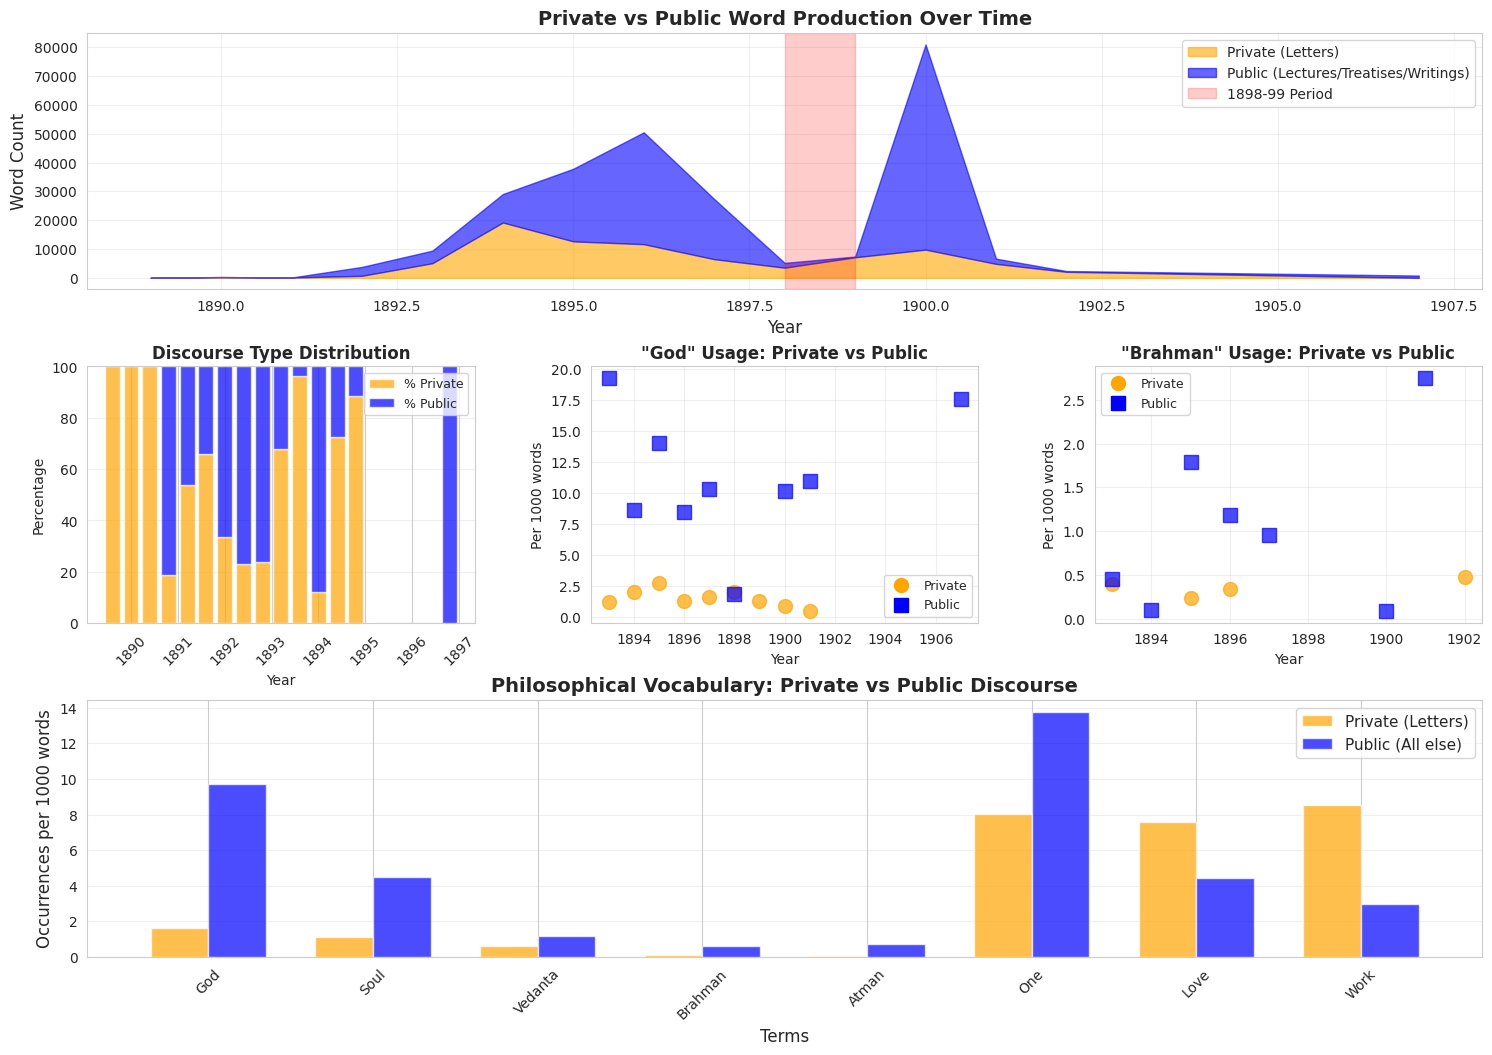


KEY FINDINGS READY - Paste output to continue with deeper questions!


In [51]:
# Cell 40: PRIVATE vs PUBLIC DISCOURSE - The Real Story
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from collections import defaultdict, Counter

print("="*80)
print("PRIVATE vs PUBLIC DISCOURSE ANALYSIS")
print("="*80)

# ============================================================
# 1. Classify documents as PRIVATE vs PUBLIC
# ============================================================

private_docs = []  # Letters
public_docs = []   # Lectures, Treatises, Writings, Other

private_tokens = []
public_tokens = []

for doc in doc_tokens:
    if doc['genre'] == 'Letters':
        private_docs.append(doc)
        private_tokens.extend([t for t in doc['tokens'] if t not in stop_words])
    else:
        public_docs.append(doc)
        public_tokens.extend([t for t in doc['tokens'] if t not in stop_words])

print(f"\nCorpus Split:")
print(f"  PRIVATE (Letters): {len(private_docs)} documents, {len(private_tokens):,} words")
print(f"  PUBLIC (All else): {len(public_docs)} documents, {len(public_tokens):,} words")
print(f"  Ratio: {len(private_docs)/(len(private_docs)+len(public_docs))*100:.1f}% private, {len(public_docs)/(len(private_docs)+len(public_docs))*100:.1f}% public")

# ============================================================
# 2. Year-wise PRIVATE vs PUBLIC breakdown
# ============================================================

private_by_year = defaultdict(list)
public_by_year = defaultdict(list)

for doc in doc_tokens:
    matching = corpus_df[corpus_df['Index'] == doc['Index']]
    if len(matching) > 0 and matching.iloc[0]['has_date']:
        year = matching.iloc[0]['year']
        tokens_clean = [t for t in doc['tokens'] if t not in stop_words]

        if doc['genre'] == 'Letters':
            private_by_year[year].extend(tokens_clean)
        else:
            public_by_year[year].extend(tokens_clean)

print("\n" + "="*80)
print("YEAR-WISE PRIVATE vs PUBLIC WORD COUNTS")
print("="*80)
print(f"\n{'Year':<6} {'Private':<10} {'Public':<10} {'%Private':<10} {'%Public':<10}")
print("-"*50)

years_data = []
for year in sorted(set(list(private_by_year.keys()) + list(public_by_year.keys()))):
    priv_count = len(private_by_year[year])
    pub_count = len(public_by_year[year])
    total = priv_count + pub_count

    if total > 0:
        priv_pct = priv_count / total * 100
        pub_pct = pub_count / total * 100
        print(f"{int(year):<6} {priv_count:<10,} {pub_count:<10,} {priv_pct:<10.1f} {pub_pct:<10.1f}")
        years_data.append({
            'year': year,
            'private': priv_count,
            'public': pub_count,
            'priv_pct': priv_pct,
            'pub_pct': pub_pct
        })

years_df = pd.DataFrame(years_data)

# ============================================================
# 3. Philosophical terms: PRIVATE vs PUBLIC
# ============================================================

print("\n" + "="*80)
print("PHILOSOPHICAL VOCABULARY: PRIVATE vs PUBLIC")
print("="*80)

key_terms = ['god', 'soul', 'vedanta', 'brahman', 'atman', 'maya', 'karma',
             'self', 'truth', 'love', 'one', 'man', 'world', 'mind']

private_freq = FreqDist(private_tokens)
public_freq = FreqDist(public_tokens)

print(f"\n{'Term':<12} {'Private':<10} {'Pub/1k':<8} {'Public':<10} {'Pub/1k':<8} {'Ratio':<8}")
print("-"*70)

for term in key_terms:
    priv_count = private_freq[term]
    pub_count = public_freq[term]

    priv_per_k = (priv_count / len(private_tokens) * 1000) if len(private_tokens) > 0 else 0
    pub_per_k = (pub_count / len(public_tokens) * 1000) if len(public_tokens) > 0 else 0

    ratio = pub_per_k / priv_per_k if priv_per_k > 0 else 0

    print(f"{term:<12} {priv_count:<10,} {priv_per_k:<8.2f} {pub_count:<10,} {pub_per_k:<8.2f} {ratio:<8.2f}x")

# ============================================================
# 4. Temporal trends: PRIVATE vs PUBLIC philosophical density
# ============================================================

print("\n" + "="*80)
print("TEMPORAL TRENDS: PHILOSOPHICAL DENSITY BY DISCOURSE TYPE")
print("="*80)

# Calculate normalized philosophical term usage per year for both
private_phil_by_year = defaultdict(dict)
public_phil_by_year = defaultdict(dict)

for year in sorted(years_df['year']):
    priv_tokens = private_by_year[year]
    pub_tokens = public_by_year[year]

    if len(priv_tokens) > 0:
        for term in ['god', 'soul', 'vedanta', 'brahman', 'atman', 'one']:
            count = sum(1 for t in priv_tokens if t == term)
            private_phil_by_year[term][year] = (count / len(priv_tokens) * 1000)

    if len(pub_tokens) > 0:
        for term in ['god', 'soul', 'vedanta', 'brahman', 'atman', 'one']:
            count = sum(1 for t in pub_tokens if t == term)
            public_phil_by_year[term][year] = (count / len(pub_tokens) * 1000)

print(f"\n{'Year':<6} {'Context':<8} {'God':<8} {'Soul':<8} {'Vedanta':<8} {'Brahman':<8} {'Atman':<8} {'One':<8}")
print("-"*70)

for year in sorted(years_df['year']):
    if year >= 1893:  # Focus on substantive years
        # Private
        if year in private_phil_by_year['god']:
            print(f"{int(year):<6} {'Private':<8} ", end="")
            for term in ['god', 'soul', 'vedanta', 'brahman', 'atman', 'one']:
                val = private_phil_by_year[term].get(year, 0)
                print(f"{val:<8.2f} ", end="")
            print()

        # Public
        if year in public_phil_by_year['god']:
            print(f"{int(year):<6} {'Public':<8} ", end="")
            for term in ['god', 'soul', 'vedanta', 'brahman', 'atman', 'one']:
                val = public_phil_by_year[term].get(year, 0)
                print(f"{val:<8.2f} ", end="")
            print()
        print()

# ============================================================
# 5. VISUALIZATIONS
# ============================================================

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: Private vs Public volume over time (stacked area)
ax1 = fig.add_subplot(gs[0, :])
years_list = sorted(years_df['year'])
private_counts = [years_df[years_df['year']==y]['private'].values[0] for y in years_list]
public_counts = [years_df[years_df['year']==y]['public'].values[0] for y in years_list]

ax1.fill_between(years_list, 0, private_counts, alpha=0.6, color='orange', label='Private (Letters)')
ax1.fill_between(years_list, private_counts, [p+pub for p,pub in zip(private_counts, public_counts)],
                 alpha=0.6, color='blue', label='Public (Lectures/Treatises/Writings)')
ax1.axvspan(1898, 1899, alpha=0.2, color='red', label='1898-99 Period')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Word Count', fontsize=12)
ax1.set_title('Private vs Public Word Production Over Time', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Percentage private vs public
ax2 = fig.add_subplot(gs[1, 0])
ax2.bar(years_list, [years_df[years_df['year']==y]['priv_pct'].values[0] for y in years_list],
        color='orange', alpha=0.7, label='% Private')
ax2.bar(years_list, [years_df[years_df['year']==y]['pub_pct'].values[0] for y in years_list],
        bottom=[years_df[years_df['year']==y]['priv_pct'].values[0] for y in years_list],
        color='blue', alpha=0.7, label='% Public')
ax2.set_xlabel('Year', fontsize=10)
ax2.set_ylabel('Percentage', fontsize=10)
ax2.set_title('Discourse Type Distribution', fontsize=12, fontweight='bold')
ax2.set_xticklabels([int(y) for y in years_list], rotation=45)
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: "God" - Private vs Public over time
ax3 = fig.add_subplot(gs[1, 1])
for year in years_list:
    if year >= 1893:
        priv_val = private_phil_by_year['god'].get(year, 0)
        pub_val = public_phil_by_year['god'].get(year, 0)
        if priv_val > 0:
            ax3.scatter(year, priv_val, color='orange', s=100, alpha=0.7, marker='o')
        if pub_val > 0:
            ax3.scatter(year, pub_val, color='blue', s=100, alpha=0.7, marker='s')

ax3.plot([], [], 'o', color='orange', label='Private', markersize=10)
ax3.plot([], [], 's', color='blue', label='Public', markersize=10)
ax3.set_xlabel('Year', fontsize=10)
ax3.set_ylabel('Per 1000 words', fontsize=10)
ax3.set_title('"God" Usage: Private vs Public', fontsize=12, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# Plot 4: "Brahman" - Private vs Public over time
ax4 = fig.add_subplot(gs[1, 2])
for year in years_list:
    if year >= 1893:
        priv_val = private_phil_by_year['brahman'].get(year, 0)
        pub_val = public_phil_by_year['brahman'].get(year, 0)
        if priv_val > 0:
            ax4.scatter(year, priv_val, color='orange', s=100, alpha=0.7, marker='o')
        if pub_val > 0:
            ax4.scatter(year, pub_val, color='blue', s=100, alpha=0.7, marker='s')

ax4.plot([], [], 'o', color='orange', label='Private', markersize=10)
ax4.plot([], [], 's', color='blue', label='Public', markersize=10)
ax4.set_xlabel('Year', fontsize=10)
ax4.set_ylabel('Per 1000 words', fontsize=10)
ax4.set_title('"Brahman" Usage: Private vs Public', fontsize=12, fontweight='bold')
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3)

# Plot 5: Comparative bar chart - key terms
ax5 = fig.add_subplot(gs[2, :])
terms_compare = ['god', 'soul', 'vedanta', 'brahman', 'atman', 'one', 'love', 'work']
x = np.arange(len(terms_compare))
width = 0.35

priv_vals = [(private_freq[t] / len(private_tokens) * 1000) for t in terms_compare]
pub_vals = [(public_freq[t] / len(public_tokens) * 1000) for t in terms_compare]

bars1 = ax5.bar(x - width/2, priv_vals, width, label='Private (Letters)', color='orange', alpha=0.7)
bars2 = ax5.bar(x + width/2, pub_vals, width, label='Public (All else)', color='blue', alpha=0.7)

ax5.set_xlabel('Terms', fontsize=12)
ax5.set_ylabel('Occurrences per 1000 words', fontsize=12)
ax5.set_title('Philosophical Vocabulary: Private vs Public Discourse', fontsize=14, fontweight='bold')
ax5.set_xticks(x)
ax5.set_xticklabels([t.title() for t in terms_compare], rotation=45)
ax5.legend(fontsize=11)
ax5.grid(True, alpha=0.3, axis='y')

plt.savefig('private_vs_public_comprehensive.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: private_vs_public_comprehensive.png")
plt.show()

print("\n" + "="*80)
print("KEY FINDINGS READY - Paste output to continue with deeper questions!")
print("="*80)